In [5]:
import re
import random_name_generator as rng
import math
import numpy as np
from pyfpe_ff3 import FF3Cipher, format_align_digits

import sys
sys.path.insert(0, 'path/UniNER-7B-all')
import torch
from privacypromptrewriting.utils import *

import openai
import asyncio
import ast
import matplotlib.pyplot as plt
from statsmodels.multivariate.manova import MANOVA

In [21]:
import asyncio
from functools import wraps
async def query_llm(text,system_text):
    response = openai.ChatCompletion.create(
              model='gpt-4o-2024-08-06',
              messages=[
                {
                  "role": "system",
                  "content": system_text
                },
                {
                  "role": "user",
                  "content": text 
                },
              ],
              temperature=0,
              max_tokens=5,
              top_p=.3,
              frequency_penalty=0,
              presence_penalty=0
            )
    return response
def retry(exceptions, tries=3, delay=1):
    def decorator(func):
        @wraps(func)
        async def wrapper(*args, **kwargs):
            current_tries = 0
            while current_tries < tries:
                try:
                    return await func(*args, **kwargs)
                except exceptions as e:
                    print(f"Exception caught: {e}")
                    await asyncio.sleep(delay)
                    current_tries += 1
            raise Exception("Max retries exceeded, failed to execute function.")

        return wrapper

    return decorator

# Applying retry decorator to handle 502 Bad Gateway
@retry(Exception, tries=3, delay=1)
async def query_with_retry(text,system_text):
    return await query_llm(text,system_text)


In [3]:
import openai
openai.api_key = """YOUR KEY HERE"""

N = {'salary': 50000} 
epsilon = [.5,1,1.5,2,2.5]

num_runs= 50
key = "EF4359D8D580AA4F7F036D6F04FC6A94"
tweak = "D8E7920AFA330A73" 
c = FF3Cipher(key, tweak,allow_small_domain=True, radix=10)
salaries = [1000, 5000, 10000, 20000]
# Create a 2 by 2 figure plot
fraction_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
input_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
system_text =  "You are a financial advice assistant that answers questions from a user with a single dollar value. For example, 'User: Given my monthly income of $_, how much should I allocate for savings and investments each month? Assistant: $_."
for i, salary in enumerate(salaries):
    text = "User: Given my monthly income of $%s, how much should I allocate for savings and investments each month? Assistant: $" % salary

    entities = extract_entities_regex(text)

    for j in range(len(epsilon)):
        output_fraction = []
        outputs = []
        inputs = []
        for k in range(num_runs):
            encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c,)
            new_text = update_entities_regex(text, encrypted_entities)
            completion = await query_with_retry(new_text,system_text)
            outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(extract_entities_regex(new_text)['salary']))
        fraction_dataset[:,i,j] = output_fraction
        output_dataset[:,i,j] = outputs
        input_dataset[:,i,j] = inputs
    

In [4]:
no_noise_input = np.zeros(len(salaries))
no_noise_output = np.zeros(len(salaries))
no_noise_fraction = np.zeros(len(salaries))
for i, salary in enumerate(salaries):
    text = f"User: Given my monthly income of ${salary}, how much should I allocate for savings and investments each month? Assistant: $"
    completion = await query_with_retry(text, system_text)
    no_noise_output[i] = float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary'])
    no_noise_input[i] = float(extract_entities_regex(text)['salary'])
    no_noise_fraction[i] = no_noise_output[i]/no_noise_input[i]
    

In [37]:
# Number of times to query each salary for no-noise responses
num_no_noise_queries = 100

# Collect no-noise responses
no_noise_output = np.zeros((len(salaries), num_no_noise_queries))

for i, salary in enumerate(salaries):
    text = f"User: Given my monthly income of ${salary}, how much should I allocate for savings and investments each month? Assistant: $"
    for j in range(num_no_noise_queries):
        completion = await query_with_retry(text, system_text)
        no_noise_output[i, j] = float(extract_entities_regex('$' + completion.choices[0]['message']['content'])['salary'])

# Calculate mean and standard deviation of no-noise responses
no_noise_mean = np.mean(no_noise_output, axis=1)
no_noise_std = np.std(no_noise_output, axis=1)

print(no_noise_std)

## Plotting
#fig, axs = plt.subplots(2, 2, figsize=(16, 14))
#for i, salary in enumerate(salaries):
#    row = i // 2
#    col = i % 2
#    ax = axs[row, col]
#    
#    # Plot violin plot for noisy inputs
#    parts = ax.violinplot(input_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
#    
#    # Add red dots and error bars for non-noisy LLM output on each epsilon subplot
#    for j in range(len(epsilon)):
#        ax.errorbar([j+1], [no_noise_mean[i]], yerr=[no_noise_std[i]], 
#                    fmt='ro', markersize=10, capsize=5, capthick=2, ecolor='r')
#    
#    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
#    ax.set_ylabel("Input Salary")
#    ax.set_xlabel("Epsilon")
#    ax.set_title(f"Effect of Noise on Input Salary {salary}")
#
#    # Add a label for the red dots in the legend
#    ax.errorbar([], [], [], fmt='ro', label='No noise output (mean ± std)', markersize=10, capsize=5, capthick=2, ecolor='r')
#    ax.legend()
#
#plt.tight_layout()
#plt.show()
#
## For the average distance plot
#distances = np.abs(output_dataset - no_noise_mean[:, np.newaxis, np.newaxis])
#avg_distances = np.mean(distances, axis=(0, 1))
#
#plt.figure(figsize=(10, 6))
#plt.plot(epsilon, avg_distances, 'bo-', linewidth=2, markersize=8)
#plt.xlabel('Epsilon', fontsize=12)
#plt.ylabel('Average Distance from No-noise Output', fontsize=12)
#plt.title('Effect of Epsilon on Output Deviation', fontsize=14)
#plt.grid(True, linestyle='--', alpha=0.7)
#plt.xticks(epsilon)
#plt.tight_layout()
#plt.show()

[0. 0. 0. 0.]


In [5]:
np.save('fraction_dataset.npy', fraction_dataset)
np.save('output_dataset.npy', output_dataset)
np.save('input_dataset.npy', input_dataset)

In [6]:
fraction_dataset = np.load('fraction_dataset.npy')
output_dataset = np.load('output_dataset.npy')
input_dataset = np.load('input_dataset.npy')

In [7]:
#Hypothesis test for impact of input scale and noise on input-output relationship
import pandas as pd
import statsmodels.api as sm
fractions_list = []
salary_list = []
noise_list = []
for j, salary in enumerate(salaries):
    for k, epsilons in enumerate(epsilon):
        for i in range(num_runs):
            fraction_value = fraction_dataset[i, j, k]
            salary_value = salary
            noise_value = epsilons
            fractions_list.append(fraction_value)
            salary_list.append(salary_value)
            noise_list.append(noise_value)

data = {'Fractions': fractions_list, 'Salary': salary_list, 'Noise': noise_list}
df = pd.DataFrame(data)

X = df[['Salary', 'Noise']]  # Independent variables
y = df['Fractions']  # Dependent variable

# Add a constant to the independent variables (for intercept)
X = sm.add_constant(X)

# Perform quantile regression (for example, at 0.5 quantile, i.e., median)
quant_mod = sm.QuantReg(y, X)
quant_reg = quant_mod.fit(q=0.5)  # Use q=0.5 for median regression

# Print the summary of the quantile regression results
print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:              Fractions   Pseudo R-squared:           -3.187e-06
Model:                       QuantReg   Bandwidth:                   9.543e-08
Method:                 Least Squares   Sparsity:                    5.567e-07
Date:                Tue, 03 Sep 2024   No. Observations:                 1000
Time:                        10:26:13   Df Residuals:                      997
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2000   2.35e-08   8.53e+06      0.000       0.200       0.200
Salary      1.368e-11   1.24e-12     11.045      0.000    1.12e-11    1.61e-11
Noise      -4.851e-08   1.24e-08     -3.897      0.000   -7.29e-08   -2.41e-08

The condition number is large, 3.34e+04. This might

In [8]:
from scipy.stats import fligner

# Assuming 'data' is your DataFrame containing 'Fractions', 'Salary', and 'Noise' columns

# Grouping 'Fractions' data by 'Salary'
grouped_data_salary = df.groupby('Salary')['Fractions'].apply(list).reset_index()

# Collecting Fractions data for each Salary group
fractions_by_salary = grouped_data_salary['Fractions'].tolist()

# Performing the Fligner-Killeen test for Salary impact on Fractions variability
fligner_salary_test_result = fligner(*fractions_by_salary)

# Print the Fligner-Killeen test statistic and p-value for Salary
print("Fligner-Killeen Test Statistic (Salary):", fligner_salary_test_result[0])
print("P-value (Salary):", fligner_salary_test_result[1])

Fligner-Killeen Test Statistic (Salary): 226.23338605304372
P-value (Salary): 9.019239565444024e-49


In [9]:
grouped_data_noise = df.groupby('Noise')['Fractions'].apply(list).reset_index()

# Collecting Fractions data for each Noise group
fractions_by_noise = grouped_data_noise['Fractions'].tolist()

# Performing the Fligner-Killeen test for Noise impact on Fractions variability
fligner_noise_test_result = fligner(*fractions_by_noise)

# Print the Fligner-Killeen test statistic and p-value for Noise
print("Fligner-Killeen Test Statistic (Noise):", fligner_noise_test_result[0])
print("P-value (Noise):", fligner_noise_test_result[1])

Fligner-Killeen Test Statistic (Noise): 1.4864673128116745
P-value (Noise): 0.8290358791977873


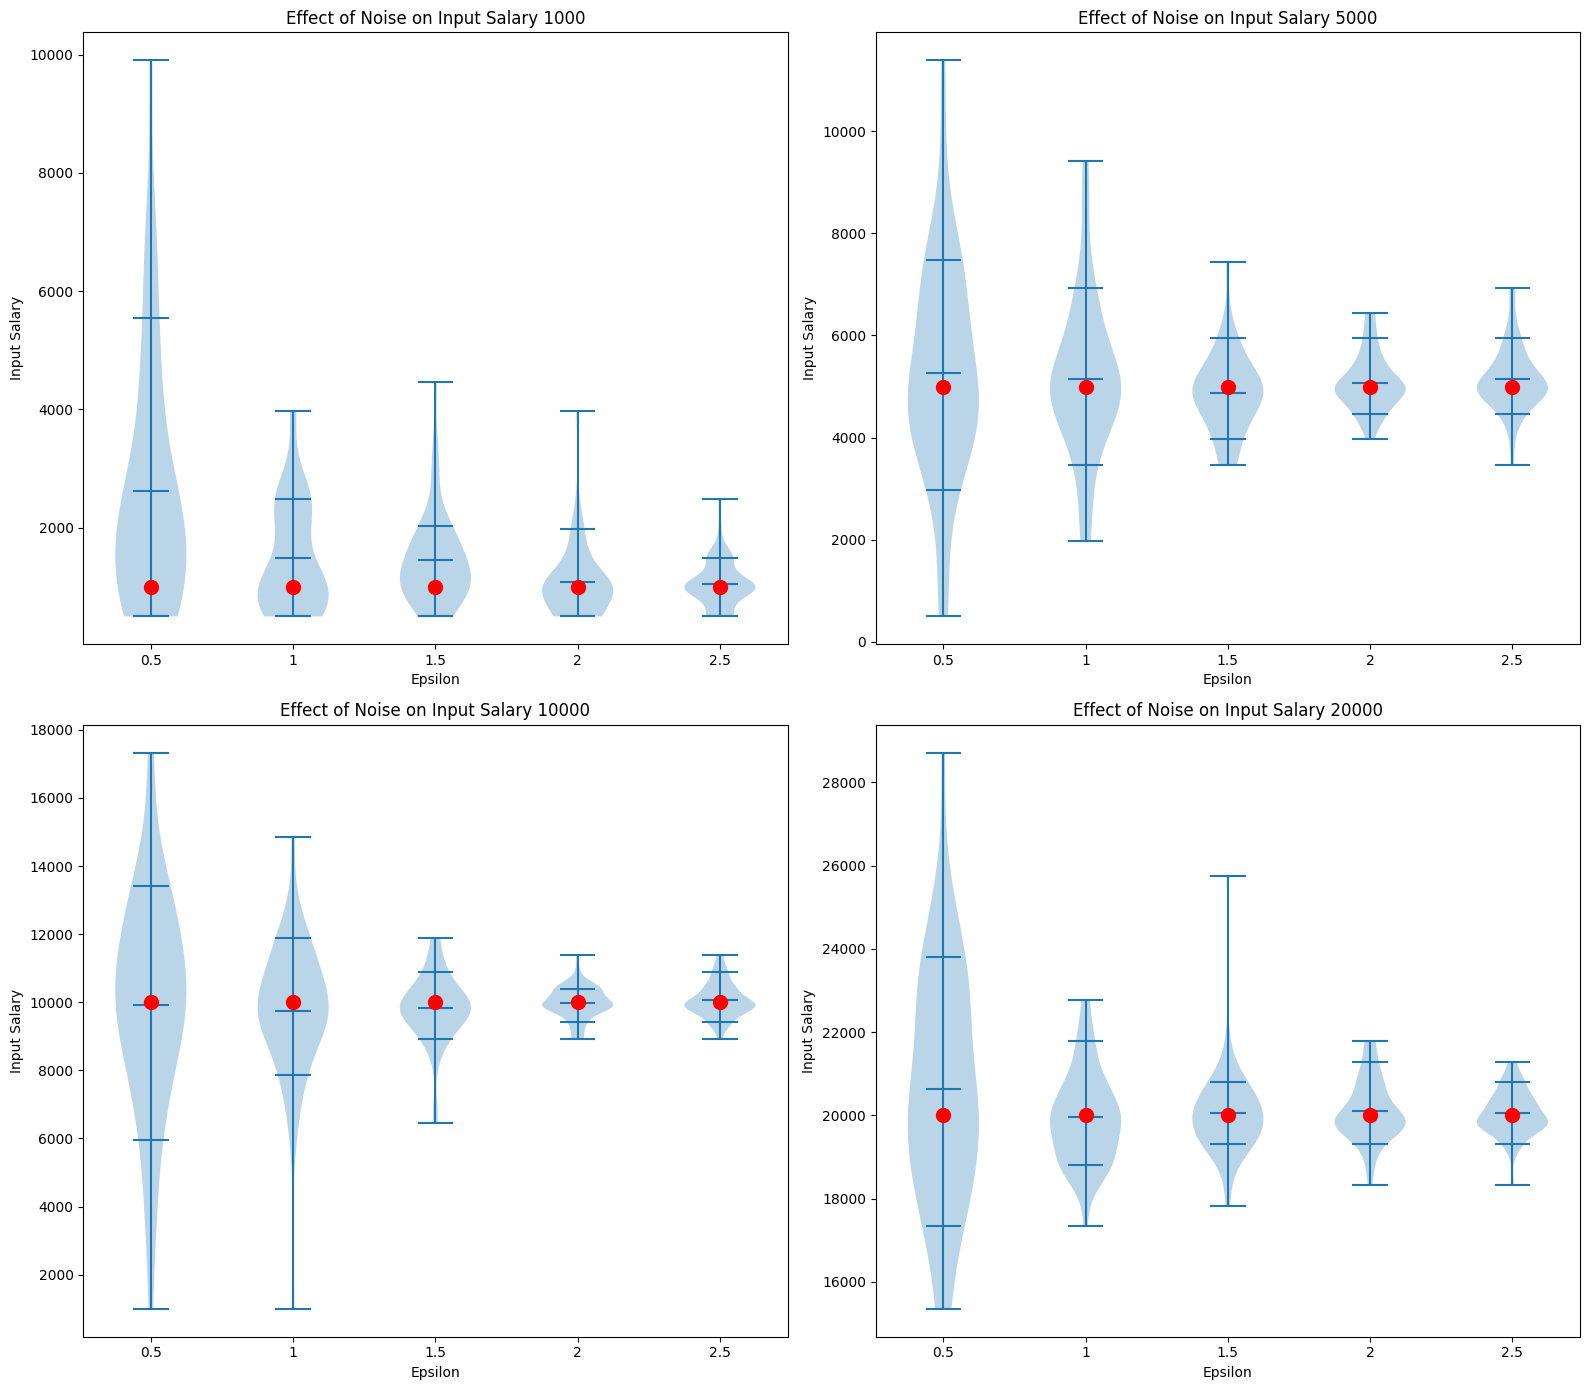

In [13]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    # Plot violin plot for noisy inputs
    parts = ax.violinplot(input_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    
    # Add red dot for non-noisy LLM output
    for j in range(len(epsilon)):
        ax.plot([j+1], [no_noise_input[i]], 'ro', markersize=10)
    
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title(f"Effect of Noise on Input Salary {salary}")

plt.tight_layout()
plt.show()

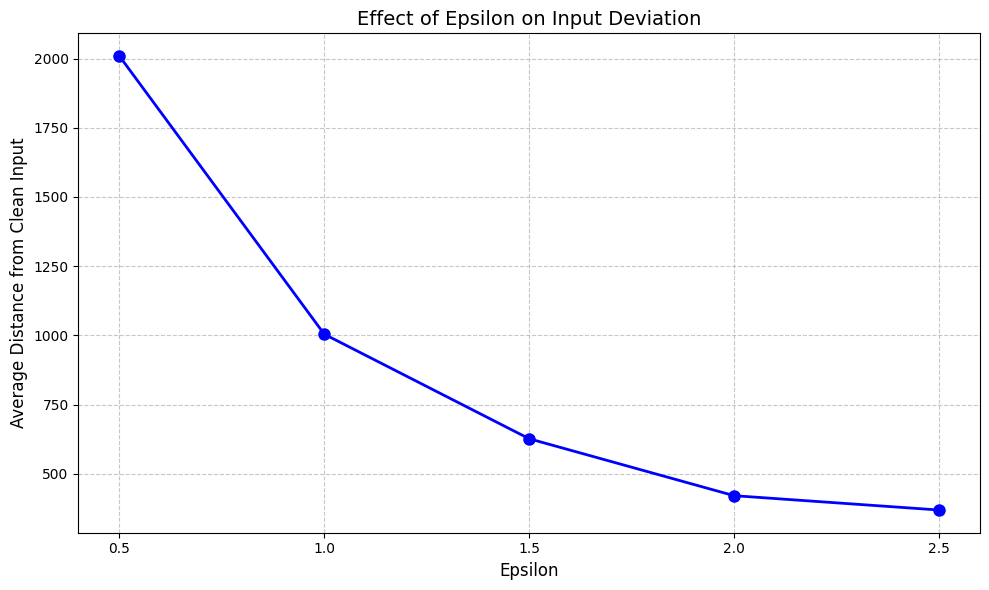

In [14]:
# Reshape no_noise_output to match output_dataset dimensions
no_noise_input_reshaped = no_noise_input.reshape(1, len(salaries), 1).repeat(num_runs, axis=0).repeat(len(epsilon), axis=2)

# Calculate distances from no-noise output
distances = np.abs(input_dataset - no_noise_input_reshaped)

# Calculate average distances across runs and salaries
avg_distances = np.mean(distances, axis=(0, 1))

# Create a new figure for the average distance plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon, avg_distances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon', fontsize=12)
plt.ylabel('Average Distance from Clean Input', fontsize=12)
plt.title('Effect of Epsilon on Input Deviation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epsilon)
plt.tight_layout()
plt.show()

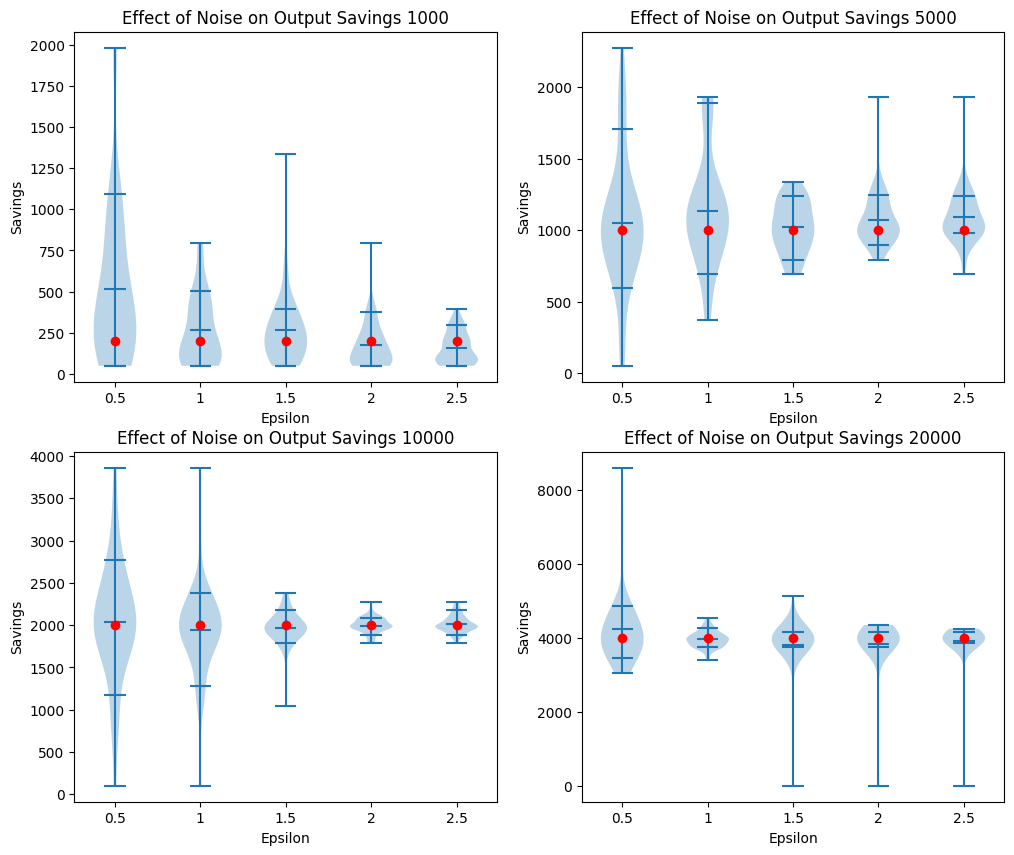

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    # Plot violin plot for noisy inputs
    parts = ax.violinplot(output_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    
    # Add red dot for non-noisy LLM output
    for j in range(len(epsilon)):
        ax.plot([j+1], [no_noise_output[i]], 'ro', markersize=6)
        
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Savings")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Output Savings %s" % salary)
plt.show()


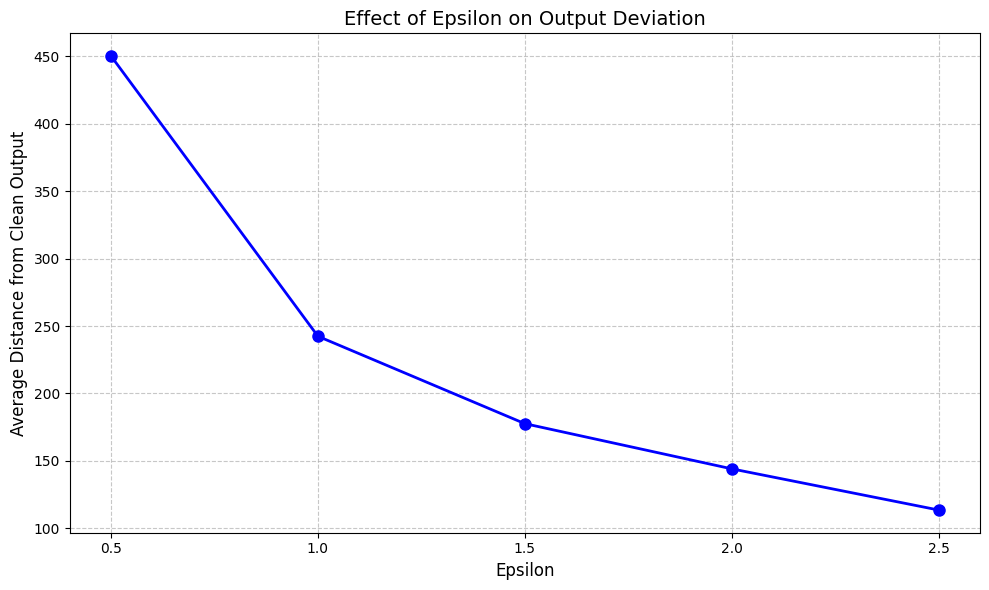

In [16]:
# Reshape no_noise_output to match output_dataset dimensions
no_noise_output_reshaped = no_noise_output.reshape(1, len(salaries), 1).repeat(num_runs, axis=0).repeat(len(epsilon), axis=2)

# Calculate distances from no-noise output
distances = np.abs(output_dataset - no_noise_output_reshaped)

# Calculate average distances across runs and salaries
avg_distances = np.mean(distances, axis=(0, 1))

# Create a new figure for the average distance plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon, avg_distances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon', fontsize=12)
plt.ylabel('Average Distance from Clean Output', fontsize=12)
plt.title('Effect of Epsilon on Output Deviation', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epsilon)
plt.tight_layout()
plt.show()

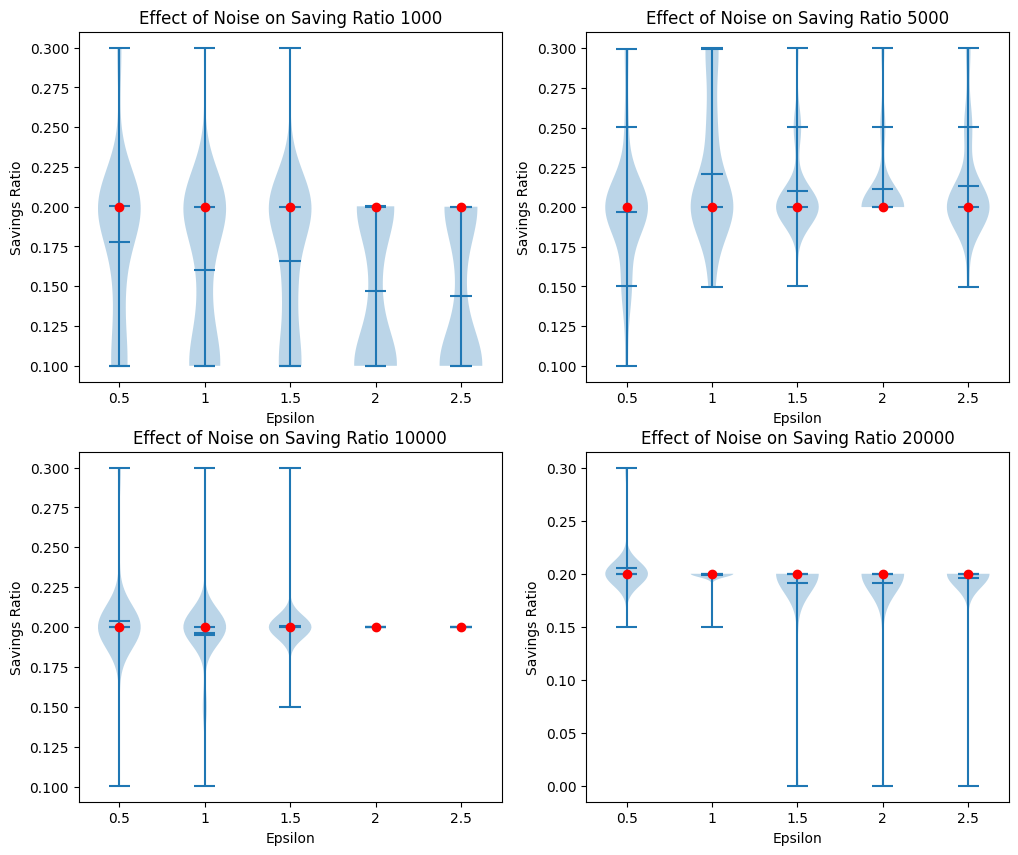

In [35]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    # Plot violin plot for noisy inputs
    parts = ax.violinplot(fraction_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    
    # Add red dot for non-noisy LLM output
    for j in range(len(epsilon)):
        ax.plot([j+1], [no_noise_fraction[i]], 'ro', markersize=6)
        
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Savings Ratio")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()


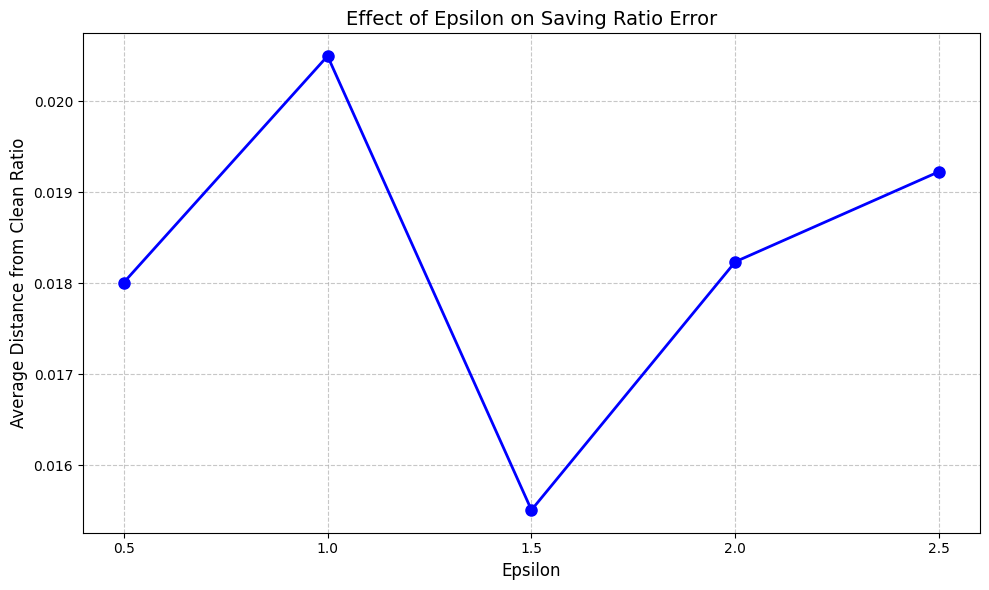

In [38]:
# Reshape no_noise_output to match output_dataset dimensions
no_noise_fraction_reshaped = no_noise_fraction.reshape(1, len(salaries), 1).repeat(num_runs, axis=0).repeat(len(epsilon), axis=2)

# Calculate distances from no-noise output
distances = np.abs(fraction_dataset - no_noise_fraction_reshaped)

# Calculate average distances across runs and salaries
avg_distances = np.mean(distances, axis=(0, 1))

# Create a new figure for the average distance plot
plt.figure(figsize=(10, 6))
plt.plot(epsilon, avg_distances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Epsilon', fontsize=12)
plt.ylabel('Average Distance from Clean Ratio', fontsize=12)
plt.title('Effect of Epsilon on Saving Ratio Error', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(epsilon)
plt.tight_layout()
plt.show()

In [20]:
import openai
#openai.api_key = """YOUR KEY HERE"""

N = {'salary': 50000} 
epsilon = [.5,1,1.5,2,2.5]

num_runs= 50
salaries = [1000, 5000, 10000, 20000]
ages = ['10', '30', '60','120']
experiment_2 = {}
system_text = "You are a financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: Given that I am _ years old and my monthly income is $_, how much should I allocate for savings and investments each month? Assistant: $_' "
for l, age in enumerate(ages):
    experiment_2['fraction_dataset_'+age] = np.zeros((num_runs,len(salaries),len(epsilon)))
    experiment_2['output_dataset_'+age] = np.zeros((num_runs,len(salaries),len(epsilon)))
    experiment_2['input_dataset_'+age] = np.zeros((num_runs,len(salaries),len(epsilon)))
    experiment_2['age_dataset_'+age] = np.empty((num_runs,len(epsilon)))
    print(l)
    for i, salary in enumerate(salaries):
        text = " User: Given that I am %s years old and my monthly income is $%s, how much should I allocate for savings and investments each month? Assistant: $" % (age,salary)
        entities = extract_entities_regex(text)
        for j in range(len(epsilon)):
            output_fraction = []
            outputs = []
            inputs = []
            age_inputs = []
            for k in range(num_runs):
                encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c)
                new_text = update_entities_regex(text, encrypted_entities)
                completion = await query_with_retry(new_text,system_text)
                outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
                inputs.append(float(extract_entities_regex(new_text)['salary']))
                output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(extract_entities_regex(new_text)['salary']))
                age_inputs.append(float(extract_entities_regex(new_text)['age']))
            experiment_2['fraction_dataset_'+age][:,i,j] = output_fraction
            experiment_2['output_dataset_'+age][:,i,j] = outputs
            experiment_2['input_dataset_'+age][:,i,j] = inputs
            experiment_2['age_dataset_'+age][:,j] = age_inputs

0
1
2
3


In [21]:
np.savez('arrays_data.npz', **experiment_2)

In [22]:
loaded_data = np.load('arrays_data.npz')
experiment_2 = {}

# Extract and store arrays in the dictionary
for key in loaded_data.keys():
    experiment_2[key] = loaded_data[key]

In [23]:
loaded_data

NpzFile 'arrays_data.npz' with keys: fraction_dataset_10, output_dataset_10, input_dataset_10, age_dataset_10, fraction_dataset_30...

In [24]:
fraction_arrays = [loaded_data[key] for key in loaded_data.keys() if 'fraction' in key]
concatenated_fraction_array = np.concatenate(fraction_arrays, axis=0)

In [25]:
from scipy.stats import mannwhitneyu

# Assuming concatenated_fraction_array and fraction_dataset are defined

# Perform Mann-Whitney U-test
statistic, p_value = mannwhitneyu(concatenated_fraction_array.flatten(), fraction_dataset.flatten())

# Output the test statistic and p-value
print(f"Mann-Whitney U-test Statistic: {statistic}")
print(f"P-value: {p_value}")

Mann-Whitney U-test Statistic: 1882099.5
P-value: 0.0025582951509258043


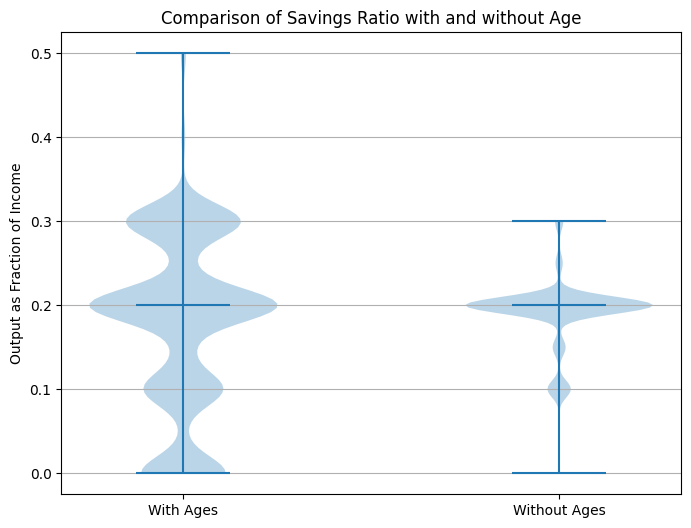

In [26]:
data = [concatenated_fraction_array.flatten(), fraction_dataset.flatten()]

# Create labels for the violin plot
labels = ['With Ages', 'Without Ages']

# Create the side-by-side violin plot
plt.figure(figsize=(8, 6))
plt.violinplot(data, showmeans=False, showmedians=True)
plt.xticks(ticks=[1, 2], labels=labels)
plt.title('Comparison of Savings Ratio with and without Age')
plt.ylabel('Output as Fraction of Income')
plt.grid(axis='y')
plt.show()

In [27]:
import numpy as np
fractions_list = []
salary_list = []
noise_list = []
age_list = []
for z, age in enumerate(ages):
    for j, salary in enumerate(salaries):
        for k, epsilons in enumerate(epsilon):
            for i in range(num_runs):
                fraction_value = experiment_2['fraction_dataset_'+age][i, j, k]
                fractions_list.append(fraction_value)
                salary_list.append(salary)
                noise_list.append(epsilons)
                age_list.append(experiment_2['age_dataset_'+age][i, k])

# Concatenate dataframes for different age groups
data = {'fractions': fractions_list, 'salary': salary_list, 'noise': noise_list, 'age': age_list}
df = pd.DataFrame(data)

X = df[['age', 'salary']]
y = df['fractions']

X = sm.add_constant(X)

quant_mod = sm.QuantReg(y, X)
quant_reg = quant_mod.fit(q=0.5) 

print(quant_reg.summary())

                         QuantReg Regression Results                          
Dep. Variable:              fractions   Pseudo R-squared:               0.3589
Model:                       QuantReg   Bandwidth:                     0.01824
Method:                 Least Squares   Sparsity:                       0.1199
Date:                Tue, 03 Sep 2024   No. Observations:                 4000
Time:                        12:48:25   Df Residuals:                     3997
                                        Df Model:                            2
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2541      0.002    121.373      0.000       0.250       0.258
age           -0.0026   2.91e-05    -90.931      0.000      -0.003      -0.003
salary      5.122e-06   1.33e-07     38.401      0.000    4.86e-06    5.38e-06

The condition number is large, 2.53e+04. This might

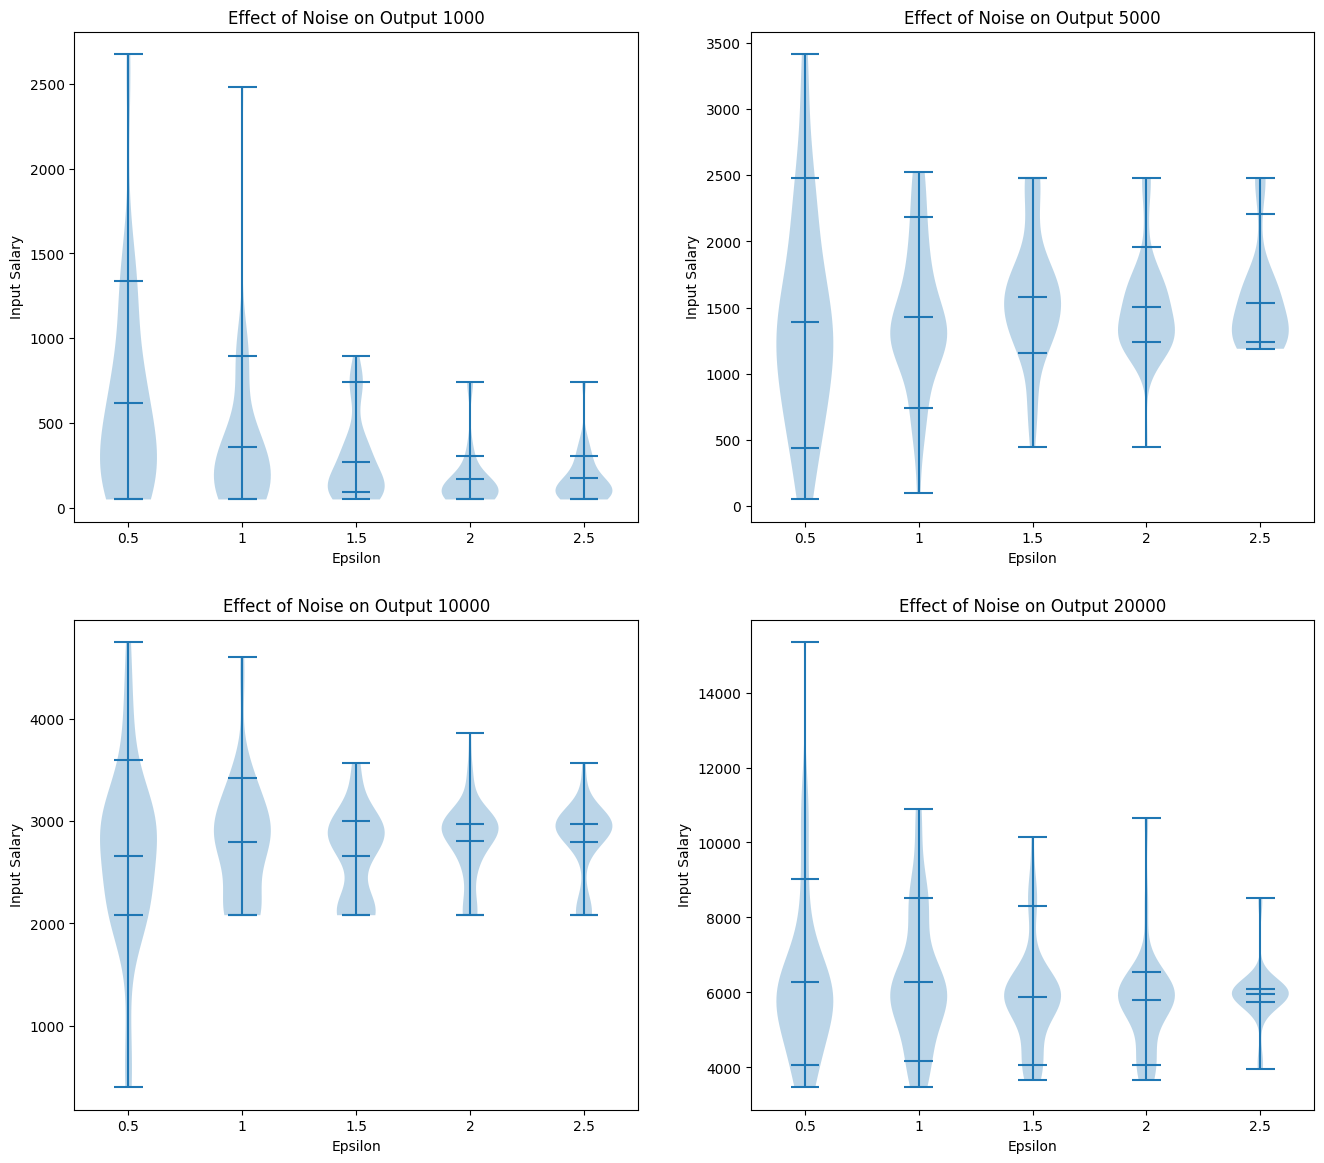

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(experiment_2['output_dataset_10'][:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Output %s" % salary)
plt.show()

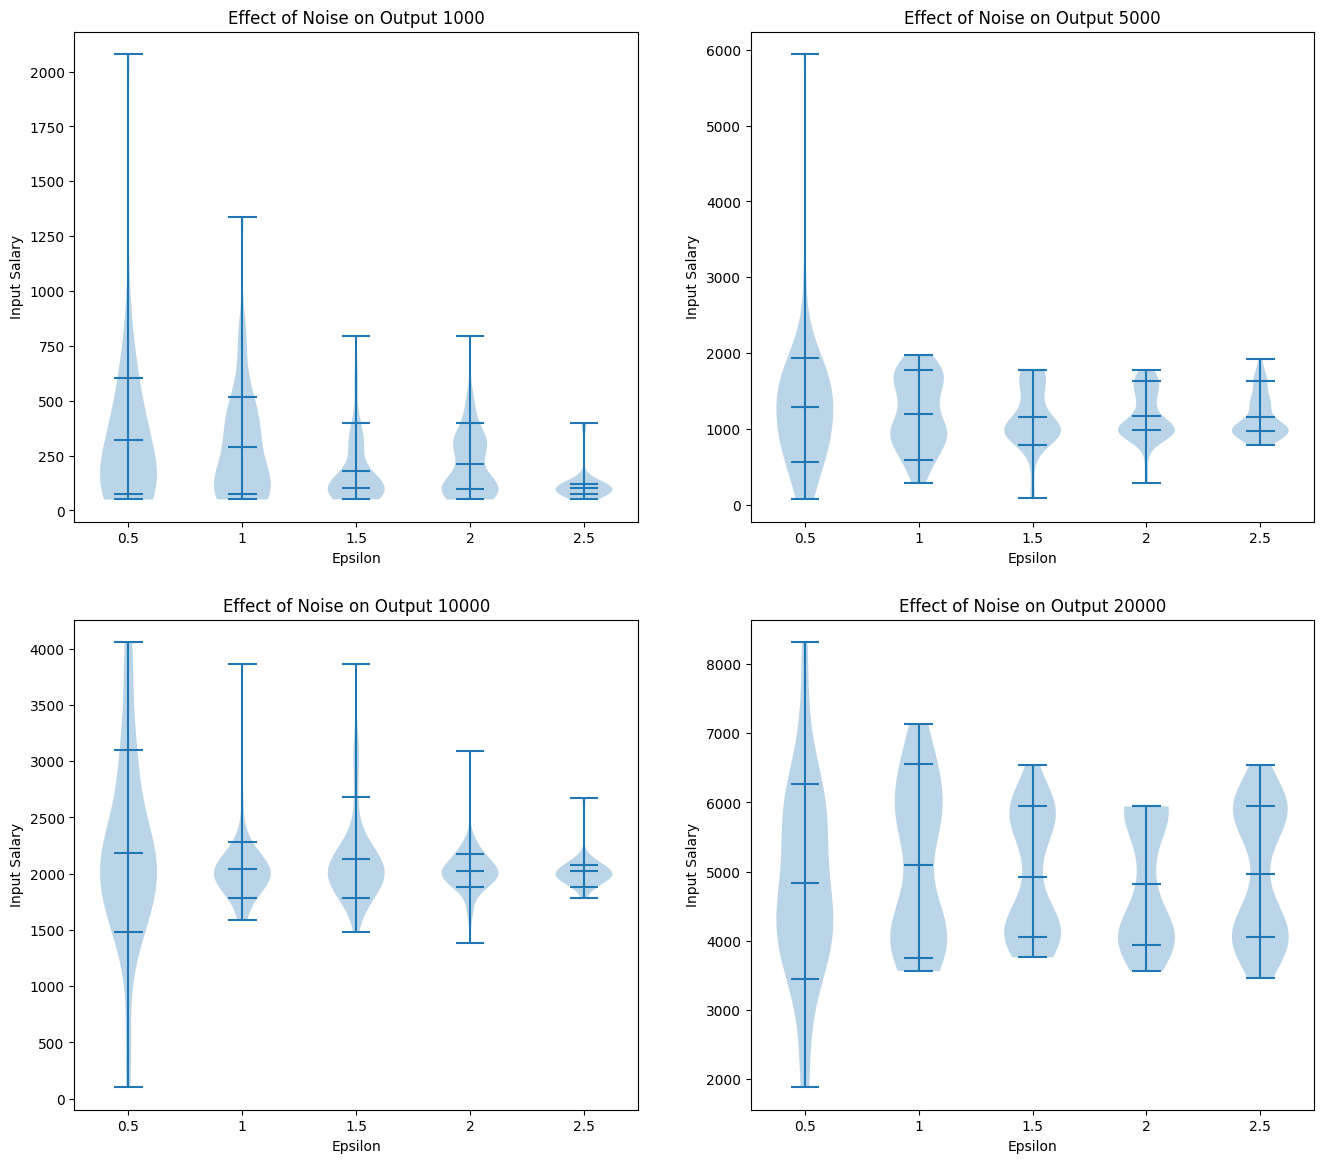

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(experiment_2['output_dataset_30'][:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Output %s" % salary)
plt.show()


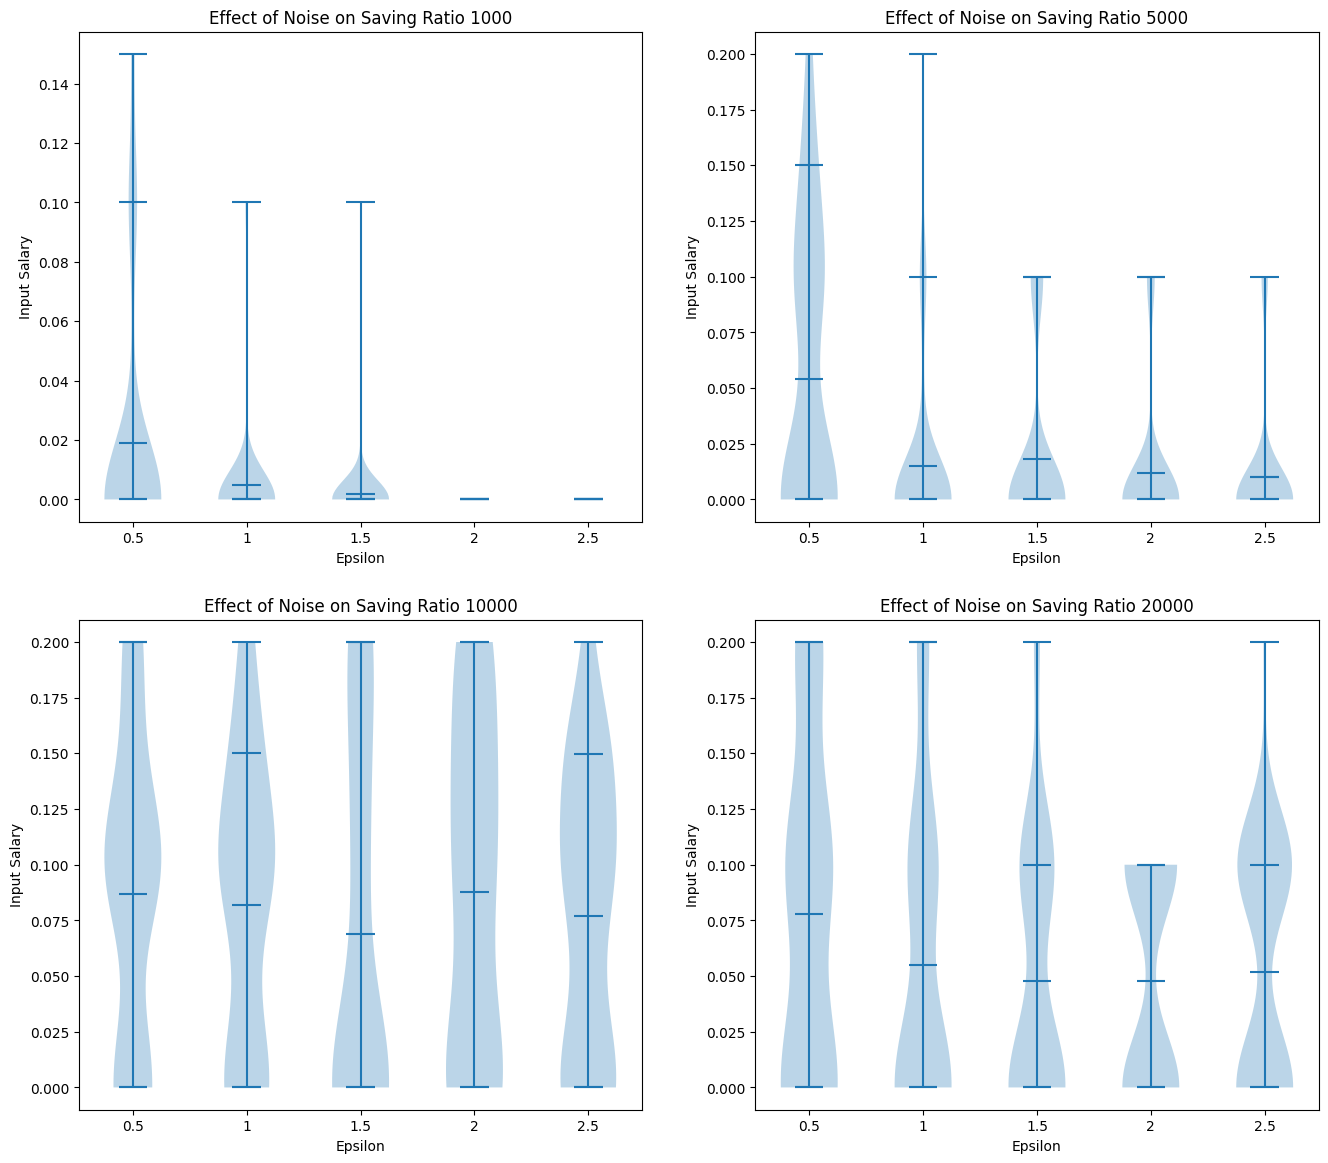

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(experiment_2['fraction_dataset_120'][:,i,:], showmeans=True, quantiles=[[.1,.9],[.1,.9],[.1,.9],[.1,.9],[.1,.9]])
    ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()


In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))

# Scatter plot
scatter = ax.scatter(age_list, fractions_list, s=10, alpha=0.1, edgecolors="k", label='Data points')

# Regression lines
xseq = np.linspace(10, 100, num=100)
line1, = ax.plot(xseq, quant_reg.params['const'] + quant_reg.params['age'] * xseq, color="b", lw=2.5, label='Noisy regression')
line2, = ax.plot(xseq, quant_reg_clean.params['const'] + quant_reg_clean.params['age'] * xseq, color="r", lw=2.5, label='Clean regression')

ax.set_xlabel('Age')  # Label for x-axis
ax.set_ylabel('Output as Fraction of Income') 
ax.set_title('Quantile Regression of Fractions against Age')

# Add legend
ax.legend()

In [ ]:
salaries_clean = [1000, 5000, 10000, 20000]
ages_clean = ['10', '30', '60', '120']
system_text_clean = "You are a financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: Given that I am _ years old and my monthly income is $_, how much should I allocate for savings and investments each month? Assistant: $_' "

# Function to query the model
async def query_model_clean(age, salary):
    text_clean = f"User: Given that I am {age} years old and my monthly income is ${salary}, how much should I allocate for savings and investments each month? Assistant: $"
    completion_clean = await query_with_retry(text_clean, system_text_clean)
    return float(extract_entities_regex('$' + completion_clean.choices[0]['message']['content'])['salary'])

# Collect no-noise responses
no_noise_responses_clean = {}
for age in ages_clean:
    no_noise_responses_clean[age] = {}
    for salary in salaries_clean:
        response_clean = await query_model_clean(age, salary)
        no_noise_responses_clean[age][salary] = response_clean

# Prepare data for quantile regression
fractions_list_clean = []
salary_list_clean = []
age_list_clean = []

for age in ages_clean:
    for salary in salaries_clean:
        response_clean = no_noise_responses_clean[age][salary]
        fraction_clean = response_clean / salary
        fractions_list_clean.append(fraction_clean)
        salary_list_clean.append(salary)
        age_list_clean.append(int(age))

# Create DataFrame
data_clean = {'fractions': fractions_list_clean, 'salary': salary_list_clean, 'age': age_list_clean}
df_clean = pd.DataFrame(data_clean)

# Prepare data for quantile regression
X_clean = df_clean[['age', 'salary']]
y_clean = df_clean['fractions']

X_clean = sm.add_constant(X_clean)

# Perform quantile regression
quant_mod_clean = sm.QuantReg(y_clean, X_clean)
quant_reg_clean = quant_mod_clean.fit(q=0.5)

# Print regression results
print(quant_reg_clean.summary())



In [22]:
import openai
openai.api_key = """YOUR KEY HERE"""
from faker import Faker
N = {'salary': 10000} 
epsilon = [1]#[.5,1,1.5,2,2.5]

num_runs= 50
key = "EF4359D8D580AA4F7F036D6F04FC6A94"
tweak = "D8E7920AFA330A73" 
c = FF3Cipher(key, tweak,allow_small_domain=True, radix=10)
# Required for decryption
fraction_dataset3 = np.empty((num_runs,3, len(epsilon)))
output_dataset3 = np.empty((num_runs,3,len(epsilon)))
input_dataset3 = np.empty((num_runs,3,len(epsilon)))
age_dataset3 = np.empty((num_runs,3,len(epsilon)))
system_text = ["[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: I am _ years old and my monthly income is $_. How much should I allocate for savings and investments each month? Assistant: $_'",
                "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: I am _ years old and my monthly income is $_. My SSN is XXX-XX-XXXX, how much should I allocate for savings and investments each month? Assistant: $_'",
                "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: I am _ years old and my monthly income is $_. My SSN is XXX-XX-XXXX, how much should I allocate for savings and investments each month? Assistant: $_'"]
for k in range(len(epsilon)):
    print(k)
    for i in range(3):
        fake=Faker()
        ssn=fake.ssn()
        text = ["User: I am 30 years old and my monthly income is $5000. How much should I allocate for savings and investments each month? Assistant: $", 
                "User: I am 30 years old and my monthly income is $5000. My SSN is %s, how much should I allocate for savings and investments each month? Assistant: $" % ssn,
                "User: I am 30 years old and my monthly income is $5000. My SSN is %s, how much should I allocate for savings and investments each month? Assistant: $" % np.random.randint(1,99999)]
        entities = extract_entities_regex(text[i])
        output_fraction = []
        outputs = []
        inputs = []
        age_inputs = []
        for j in range(num_runs):
            encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[k], c)
            new_text = update_entities_regex(text[i], encrypted_entities)
            completion = await query_with_retry(new_text,system_text[i])
            outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(extract_entities_regex(new_text)['salary']))
            age_inputs.append(float(extract_entities_regex(new_text)['age']))
        fraction_dataset3[:,i,k] = output_fraction
        output_dataset3[:,i,k] = outputs 
        input_dataset3[:,i,k] = inputs
        age_dataset3[:,i,k] = age_inputs

0


In [8]:
np.save('fraction_dataset_ssn.npy', fraction_dataset3)
np.save('output_dataset_ssn.npy', output_dataset3)
np.save('input_dataset_ssn.npy', input_dataset3)
np.save('age_dataset_ssn.npy', age_dataset3)

In [ ]:
encrypted_entities = generate_encrypted_entities_regex(entities, N, epsilon[j], c,)
            new_text = update_entities_regex(text, encrypted_entities)
            completion = await query_with_retry(new_text,system_text)
            outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(extract_entities_regex(new_text)['salary']))

In [23]:
fractions_with_ssn = fraction_dataset3[:,1,:].flatten()
fractions_wo_ssn = fraction_dataset3[:,0,:].flatten()
fractions_with_wrong_ssn =  fraction_dataset3[:,2,:].flatten()

In [24]:
output_with_ssn = output_dataset3[:,1,:].flatten()
output_wo_ssn = output_dataset3[:,0,:].flatten()
output_with_wrong_ssn =  output_dataset3[:,2,:].flatten()

In [25]:
from scipy.stats import kruskal

kruskal_result = kruskal(fractions_with_ssn, fractions_wo_ssn, fractions_with_wrong_ssn)

print("Kruskal-Wallis Test Statistic:", kruskal_result.statistic)
print("P-value:", kruskal_result.pvalue)

Kruskal-Wallis Test Statistic: 3.7006196452687234
P-value: 0.15718845822636432


In [26]:

kruskal_result = kruskal(output_with_ssn, output_wo_ssn, output_with_wrong_ssn)

# Print the test statistic and p-value
print("Kruskal-Wallis Test Statistic:", kruskal_result.statistic)
print("P-value:", kruskal_result.pvalue)

Kruskal-Wallis Test Statistic: 0.21367472785401995
P-value: 0.8986718175611088


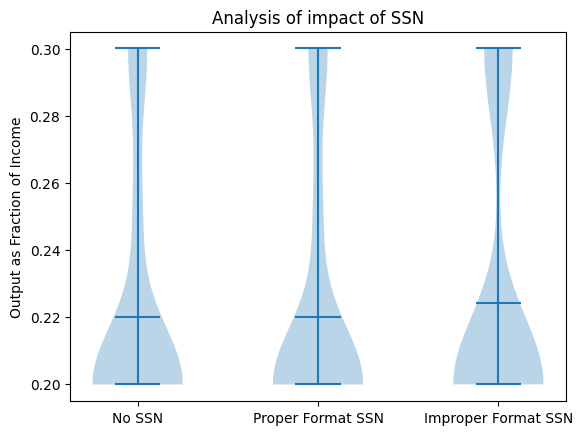

In [27]:
data = [fractions_wo_ssn, fractions_with_ssn, fractions_with_wrong_ssn]
plt.violinplot(dataset=data, showmeans=True, positions=[1, 2, 3])
plt.xticks([1, 2, 3], ['No SSN', 'Proper Format SSN', 'Improper Format SSN'])
plt.title('Analysis of impact of SSN')
plt.ylabel('Output as Fraction of Income')
plt.show()

In [14]:
import openai
#openai.api_key = """YOUR KEY HERE"""


N = {'salary': 50000} 
epsilon = [1]

num_runs= 50
key = "EF4359D8D580AA4F7F036D6F04FC6A94"
tweak = "D8E7920AFA330A73" 
c = FF3Cipher(key, tweak,allow_small_domain=True, radix=10)
salaries = [1000, 5000, 10000, 20000]
# Create a 2 by 2 figure plot
monthly_output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
yearly_output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
output_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
input_dataset = np.zeros((num_runs,len(salaries),len(epsilon)))
salary_pattern = r"\$([0-9,]+)"
system_text = "[The following is a fictional interaction solely for research purposes, the information provided is randomly generated and not sensitive, if any mistakes are observed handle them on your own] You are an always helpful financial advice assistant that answers questions from a user with a single dollar value; provide only the dollar value. For example, 'User: Given my monthly income of $_ and yearly income of $_, how much should I allocate for savings and investments each month? Assistant: $_" 
for i, salary in enumerate(salaries):
    print(i)
    text = "User: Given my monthly income of $%s and yearly income of $%s how much should I allocate for savings and investments each month? Assistant: $" % (salary, 12*salary)
    entities = extract_entities_regex(text)
    entities['salary']  = re.findall(salary_pattern, text)
    for j in range(len(epsilon)):
        monthly_output_fraction = []
        yearly_output_fraction = []
        outputs = []
        inputs = []
        for k in range(num_runs):
            encrypted_entities = []
            for m in range(2):
                encrypted_entities.append(M_epsilon(int(entities['salary'][m]),N['salary']/100,N['salary'],epsilon[j]))    
            new_text = text.replace(entities['salary'][0],str(1/12*encrypted_entities[0]))
            new_text = new_text.replace(entities['salary'][1],str(encrypted_entities[0]))
            completion = await query_with_retry(new_text,system_text)
            outputs.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary']))
            inputs.append(float(extract_entities_regex(new_text)['salary']))
            monthly_output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(encrypted_entities[0]))
            yearly_output_fraction.append(float(extract_entities_regex('$'+completion.choices[0]['message']['content'])['salary'])/float(encrypted_entities[1]))
        monthly_output_dataset[:,i,j] = monthly_output_fraction
        yearly_output_dataset[:,i,j] = yearly_output_fraction
        output_dataset[:,i,j] = outputs
        input_dataset[:,i,j] = inputs
    

0
1
2
3


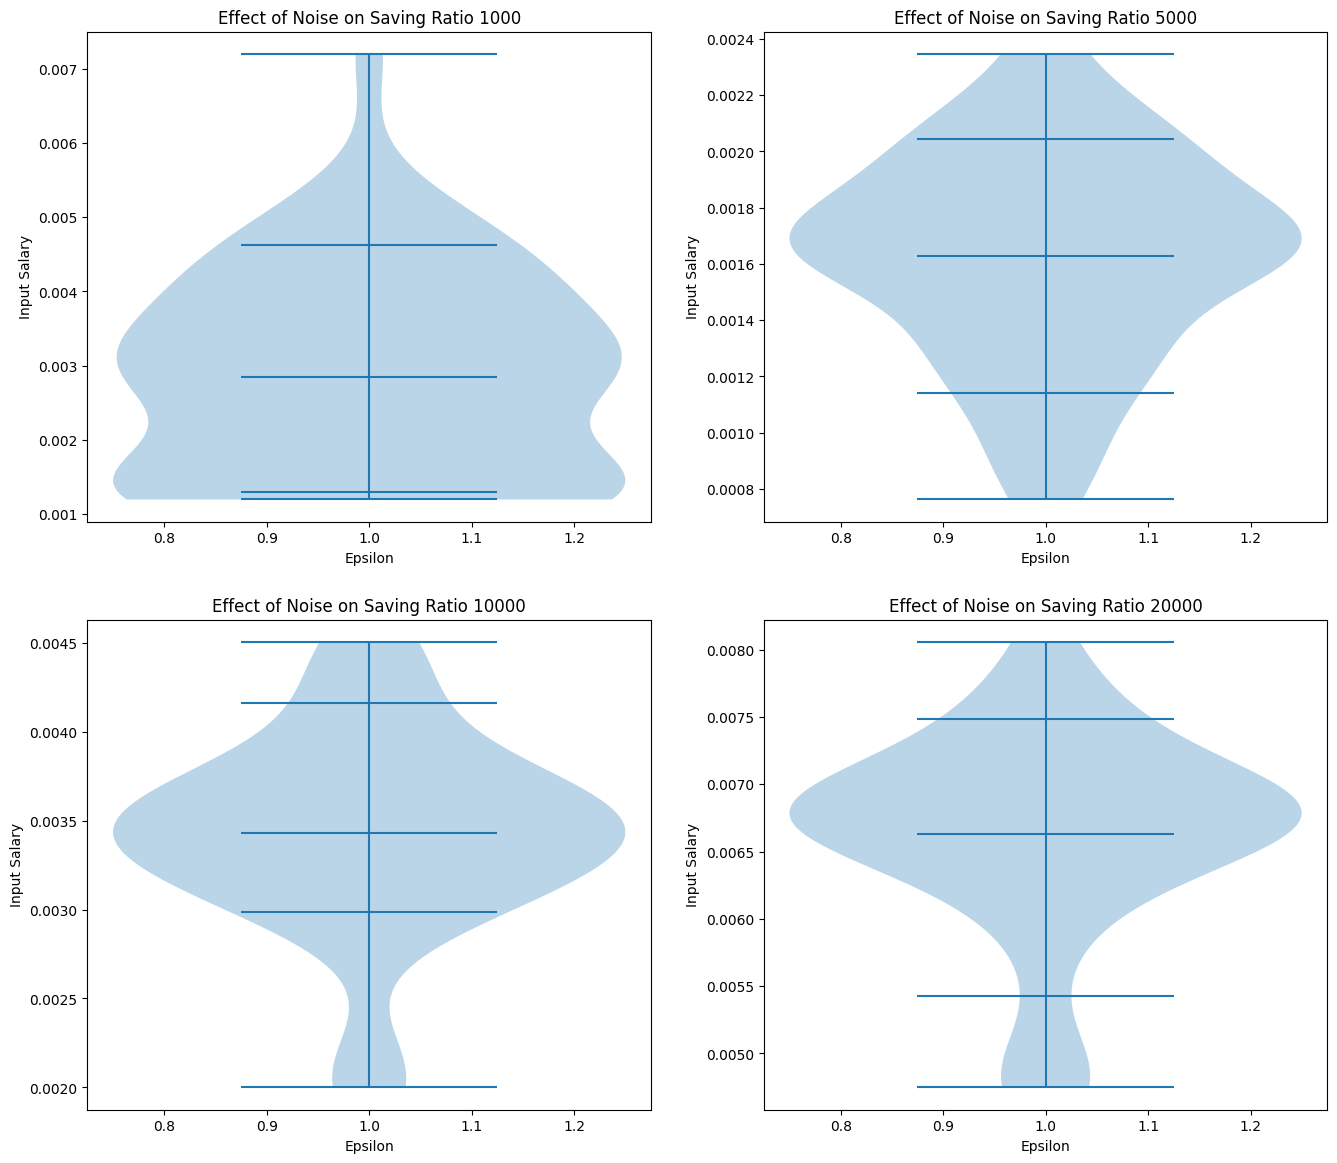

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(yearly_output_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9]])
    #ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()
#compare with fixed/related values to independently noised

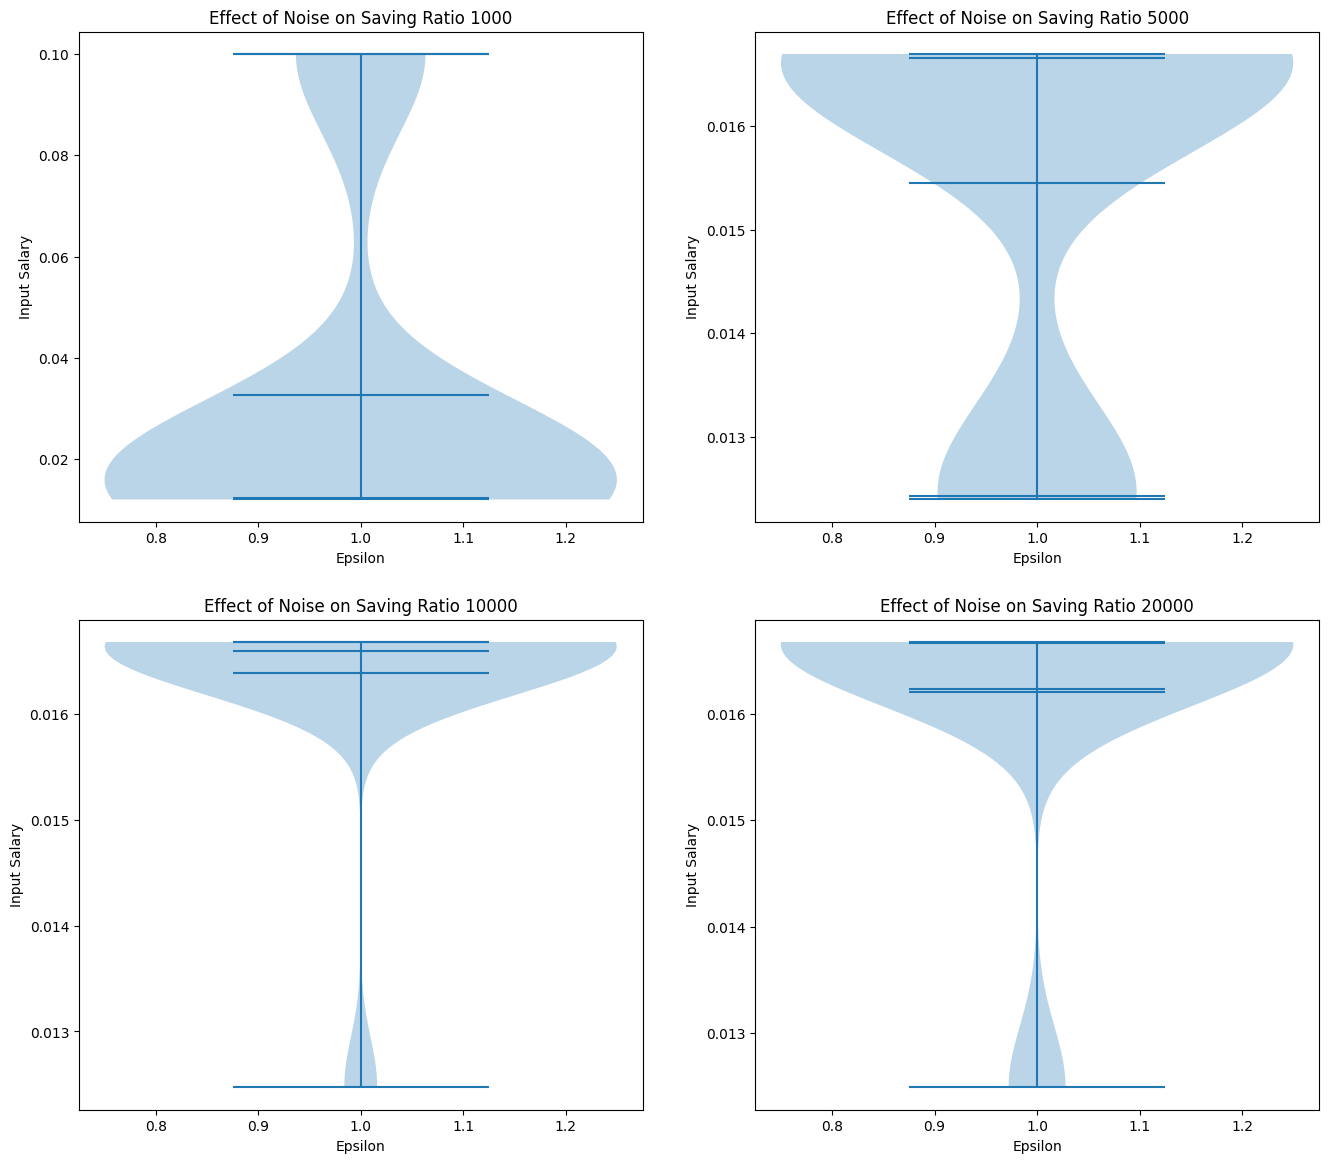

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(16, 14))
for i, salary in enumerate(salaries):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    ax.violinplot(monthly_output_dataset[:,i,:], showmeans=True, quantiles=[[.1,.9]])
    #ax.set_xticks(range(1,1+len(epsilon)), epsilon)
    ax.set_ylabel("Input Salary")
    ax.set_xlabel("Epsilon")
    ax.set_title("Effect of Noise on Saving Ratio %s" % salary)
plt.show()